In [1]:
import foundation
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from foundation.LLM.LLM_multi_agent import LLM_Agent2 as LLM_Agent
from foundation.LLM.behavior_tree_agent import LLM_Agent3 as tree_agent
from foundation.LLM.random_agent import LLM_Agent4 as random_agent
from foundation.LLM.ReAct import ReAct as ReAct
from foundation.LLM.Act import Act as Act
from foundation.LLM.Reflexion import Reflexion as Reflexion
from foundation.LLM.person_agent import Person_Agent
from foundation.utils import plotting
import logging
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
import pandas as pd
from IPython import display
from datetime import datetime
import json
from copy import deepcopy
month_day = datetime.now().strftime("%m_%d")
logging.basicConfig(filename='../gpt3.5_' + month_day + '_cycle_70_10_off.log', level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
env_config = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'scenarios/sinkhole',

    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #     "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #     {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        ('Upgrade', dict(upgrade_income=10.0, upgrade_labor=1.0)),
        ('Task', dict(move_labor=1.0, collect_labor=10.0)),
        ('Recharge', dict(recharge_income=10.0, recharge_labor=1.0)),
        ('Market', dict(order_labor=1.0, max_num_orders=5)),
        ('Shop', dict(shop_labor=1.0)),
        ('Bargain', dict(bargain_labor=1.0)),
        ('LaunchReadjustment', dict(is_biadjustment=True, adjustment_period=50, adjustment_rate_max=0.2, adjustment_rate_min=0.0, adjustment_rate_bin=0.1))
    ],

    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    'base_launch_plan': {
        'Exp': 70,
        'Mat': 200,
        'Token': 70
    },
    'starting_player_token': 0,
    'starting_player_currency': 200,
    'normal_wear_and_tear_rate': 0.05,
    'player_monetary_cost_dist': 'pareto', 
    'player_nonmonetary_cost_dist': 'normal',
    'player_utility_income_fxrate': 0.2,
    'adjustemt_type': 'none', #'planner',
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 10,          # Number of non-planner agents (must be >1)
    'world_size': [50, 50],  # [Height, Width] of the env world
    'episode_length': 1000,  # Number of timesteps per episode
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    'allow_observation_scaling': True,
    'full_observability': False,
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': False,
    'seed':42,
}

In [3]:
def sample_LLM_action(args):
    """Sample random UNMASKED action(s) for agent."""
    # Return a list of actions: 1 for each action subspace
    agent, a_obs, resources_maps, agent_locs, llm_agent = args
    
    if agent.multi_action_mode:
        # split_masks = np.split(a_obs['action_mask'], agent.action_spaces.cumsum()[:-1])
        # return agent.idx,  [np.random.choice(np.arange(len(m_)), p=m_/m_.sum()) for m_ in split_masks]
        return [0 for _ in range(len(a_obs['action_mask']))]
    # Return a single action
    else:
        market_hist = {}
        market_hist['market_rate'] = a_obs['Market-market_rate-Mat']
        market_hist['available_asks'] = a_obs['Market-available_asks-Mat']
        market_hist['available_bids'] = a_obs['Market-available_bids-Mat']
        market_hist['my_asks'] = a_obs['Market-my_asks-Mat']
        market_hist['my_bids'] = a_obs['Market-my_bids-Mat']
        market_hist['all_ask_hists'] = a_obs['Market-all_asks-Mat']
        # llm_agent = llm_agents[agent.idx]
        action = llm_agent.generate_action(agent.inventory, agent.escrow, agent.endogenous['Capability'], resources_maps, agent_locs, market_hist, bargain_message = a_obs.get('Bargain-bargain_msg', None), masks=a_obs['action_mask'])
        '''print(action)
        print(llm_agent.step)'''
        # llm_agents[agent.idx] = llm_agent
        #return llm_agent.generate_action(agent.inventory, agent.endogenous['Capability'], resources_maps, agent_locs, market_hist, bargain_message = a_obs.get('Market-bargain_msg-Mat', None))
        return action


def sample_LLM_actions(env, obs, LLM_agents, executor, multithread = True):
    """Samples random UNMASKED actions for each agent in obs."""
    maps = env.world.maps
    resource = ['Exp', 'Mat', 'Token']
    resources_maps = {k : maps.get(k) for k in resource}
    '''actions = {
        a_idx: sample_LLM_action(env.get_agent(a_idx), a_obs['action_mask'], resources_maps, a_obs['Market-market_rate-Mat'], LLM_agents[int(a_idx) if a_idx.isdigit() else None])
        for a_idx, a_obs in obs.items()
    }'''
    actions = {}
    agent_locs = [agent.loc for agent in env.world.agents]
    """manager = multiprocessing.Manager()
    shared_agents = manager.dict(LLM_agents)
    # chunks = [(env.get_agent(a_idx), a_obs, resources_maps, agent_locs, LLM_agents[int(a_idx)] if a_idx.isdigit() else None) for a_idx, a_obs in obs.items()]
    chunks = [(env.get_agent(a_idx), a_obs, resources_maps, agent_locs, shared_agents) for a_idx, a_obs in obs.items() if a_idx == 'p' or not isinstance(LLM_agents[int(a_idx)], Person_Agent)]
    with multiprocessing.Pool(processes=len(chunks)) as pool:
        results = pool.map(sample_LLM_action, chunks)"""
    if multithread:
        chunks = [(env.get_agent(a_idx), a_obs, resources_maps, agent_locs, LLM_agents[int(a_idx)] if a_idx != 'p' else None) for a_idx, a_obs in obs.items() if a_idx == 'p' or not isinstance(LLM_agents[int(a_idx)], Person_Agent)]
        for idx, action in zip(
            obs.keys(),
            executor.map(sample_LLM_action, chunks),
        ):
            actions[idx] = action

    for a_idx, a_obs in obs.items():
        if a_idx != 'p' and isinstance(LLM_agents[int(a_idx)], Person_Agent):
            idx, action = sample_LLM_action((env.get_agent(a_idx), a_obs, resources_maps, agent_locs, LLM_agents[int(a_idx)]))
            actions[int(a_idx)] = action
    # print(results)
    #actions = {a_idx:action for a_idx, llm_agent,action in results}
    
    # LLM_agents = {a_idx : dill.loads(llm_agent) for a_idx,llm_agent,_ in results if a_idx != 'p'}
    return actions

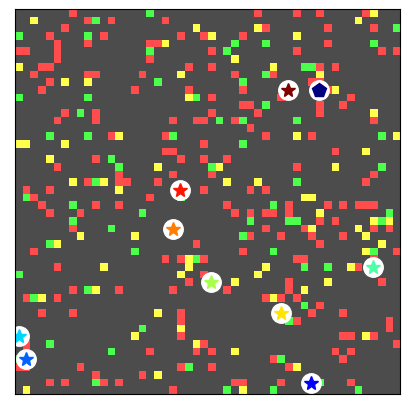

In [4]:
env = foundation.make_env_instance(**env_config)
env.reset()
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
plotting.do_plot(env, ax1, fig)
display.clear_output(wait=True)
all_asks, all_bids = [], []

In [5]:

LLM_agents = {}
# profiles = ['grind','pay','balance','seller','grind']
df = pd.read_csv('profiles3.csv')
profiles = df['player_profile'].tolist()[:env.n_agents]
profiles2 = ["You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability." for _ in range(5)]
profiles = profiles2 + profiles
off_rates = [0 for _ in range(5)] + df['off_rate'].tolist()[:env.n_agents]
print(profiles)
print(off_rates)
n_profile = len(profiles)
for i in range(env.n_agents):
    if i >= 30:
        # LLM_agents[i] = random_agent(player_profile=None, agent_id=i)
        LLM_agents[i] = tree_agent(player_profile=None, agent_id=i)
    else:
        LLM_agents[i] = LLM_Agent(player_profile=profiles[i%n_profile], agent_id=i, off_rate=off_rates[i])
        # LLM_agents[i] = ReAct(player_profile=profiles[i%n_profile], agent_id=i)
        # LLM_agents[i] = Reflexion(player_profile=profiles[i%n_profile], agent_id=i)
        # LLM_agents[i] = Act(player_profile=profiles[i%n_profile], agent_id=i)
decision_seqs = [[] for i in range(env.n_agents)]

["You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You are highly active in the game, focusing on g

In [6]:

def play_random_episode(env, plot_every=100, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.

    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop

    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
    
    file = open('output_actions_0521.txt', 'a')
    file.write('Starting Game! \n')
    
    # Testing!
    obs = env.reset(force_dense_logging=do_dense_logging)
    # obs = env._generate_observations()
    adjustment_rates = env.components[-1].adjustment_rates
    
    plotting.do_plot(env, ax1, fig)

    with ThreadPoolExecutor(max_workers=10) as executor:
        for t in range(env.episode_length):
            logging.info('Step ' + str(t) + '======================================= \n')
            actions = sample_LLM_actions(env, obs, LLM_agents, executor)
            logging_actions = deepcopy(actions)
            for k,v in actions.items():
                if k == 'p':
                    del logging_actions[k]
                else:
                    '''k = int(k)
                    if isinstance(v, dict):
                        decision_seqs[int(k)].append(list(v.keys())[0])
                    else:
                        decision_seqs[int(k)].append("Offline")'''
                    k = int(k)
                    if isinstance(LLM_agents[k], Person_Agent):
                        logging_actions[k] = {'action':v, 'type':'Person'}
                    elif isinstance(LLM_agents[k], LLM_Agent):
                        logging_actions[k] = {'action':v, 'type':'LLM'}
                    elif isinstance(LLM_agents[k], ReAct):
                        logging_actions[k] = {'action':v, 'type':'ReAct'}
                    elif isinstance(LLM_agents[k], Reflexion):
                        logging_actions[k] = {'action':v, 'type':'Reflexion'}
                    else:
                        logging_actions[k] = {'action':v, 'type':'Random'}
            file.write(json.dumps(logging_actions) + '\n')

            all_asks.append((obs["2"]['Market-available_asks-Mat'] + obs["2"]['Market-my_asks-Mat']).tolist())
            all_bids.append((obs["2"]['Market-available_bids-Mat'] + obs["2"]['Market-my_bids-Mat']).tolist())
            if t % 10 == 9:
                trades_file = open('trades_0521.txt','w')
                trades_file.write(json.dumps([all_asks, all_bids]))
            if t % 50 == 49:
                dense_log_file = open('dense_log_cp.json', 'w')
                env._finalize_logs()
                dense_log = env.previous_episode_dense_log
                dense_log_file.write(json.dumps(dense_log))
            obs, rew, done, info = env.step(actions)
            display.clear_output(wait=True)
            ax2.clear()

            readjustment_plan = {k:adjustment_rates[int(v)-1] if v!=0 else 0 for k,v in zip(["Exp", "Mat", "Token"], actions['p'])}
            planner_launch_plan = {k: int(env.base_launch_plan[k]*(1+v)) for k, v in readjustment_plan.items()}
            for k,v in readjustment_plan.items():
                if v==0:
                    readjustment_plan[k] = 'NO-OP'
                elif v>0:
                    readjustment_plan[k] = '+' + str(v*100) + '%'
                else:
                    readjustment_plan[k] = '-' + str(abs(v)*100) + '%'
            
            text = 'Steps: ' + str(t) + ' Durations: ' + str(env._durations) +'\n'
            text += 'Default launch plan: ' + str(env.base_launch_plan) + '\n'
            text += 'Current launch plan: ' + str(env.curr_launch_plan) + '\n'
            text += 'Last launch plan: ' + str(env.last_launch_plan) + '\n\n'

            metrics = env.scenario_metrics()
            text += 'Profitability: ' + str(round(metrics['social/productivity'], 2))+ ', Equality: ' +  str(round(metrics['social/equality'], 2)) +'\n'
            text += 'Planner: '+ str(readjustment_plan) +'\n'
            text += 'Planner launch plan: ' + str(planner_launch_plan)+ '\n\n\n'

            for i in range(len(env.all_agents)-1):
                act = env.dense_log["actions"][t][str(i)]
                act = act if len(act) > 0 else {'NO-OP': 1}
                decision_seqs[i].append(list(act.keys())[0])
                text += 'Agent: ' + str(i) + ' :\nAction: ' + str(act) + '\nInventory: ' + str(env.world.agents[i].inventory) + '\nescrow: ' + str(
                    env.world.agents[i].escrow) + '\nEndogenous: ' + str(
                    env.world.agents[i].endogenous) + '\n================================\n'
            ax2.text(0.05, 0., text, fontsize=18)
            plt.xticks([])
            plt.yticks([])

            if ((t+1) % plot_every) == 0:
                plotting.do_plot(env, ax1, fig)

    if ((t+1) % plot_every) != 0:
        plotting.do_plot(env, ax1, fig)

    for idx in range(len(LLM_agents)):
        print('agent ' + str(idx) + '\'s total online steps: ' + str(LLM_agents[idx].total_online_steps))
        if isinstance(LLM_agents[idx], LLM_Agent):
            print('agent ' + str(idx) + '\'s total LLM numbers: ' + str(LLM_agents[idx].LLM_number))
    
    


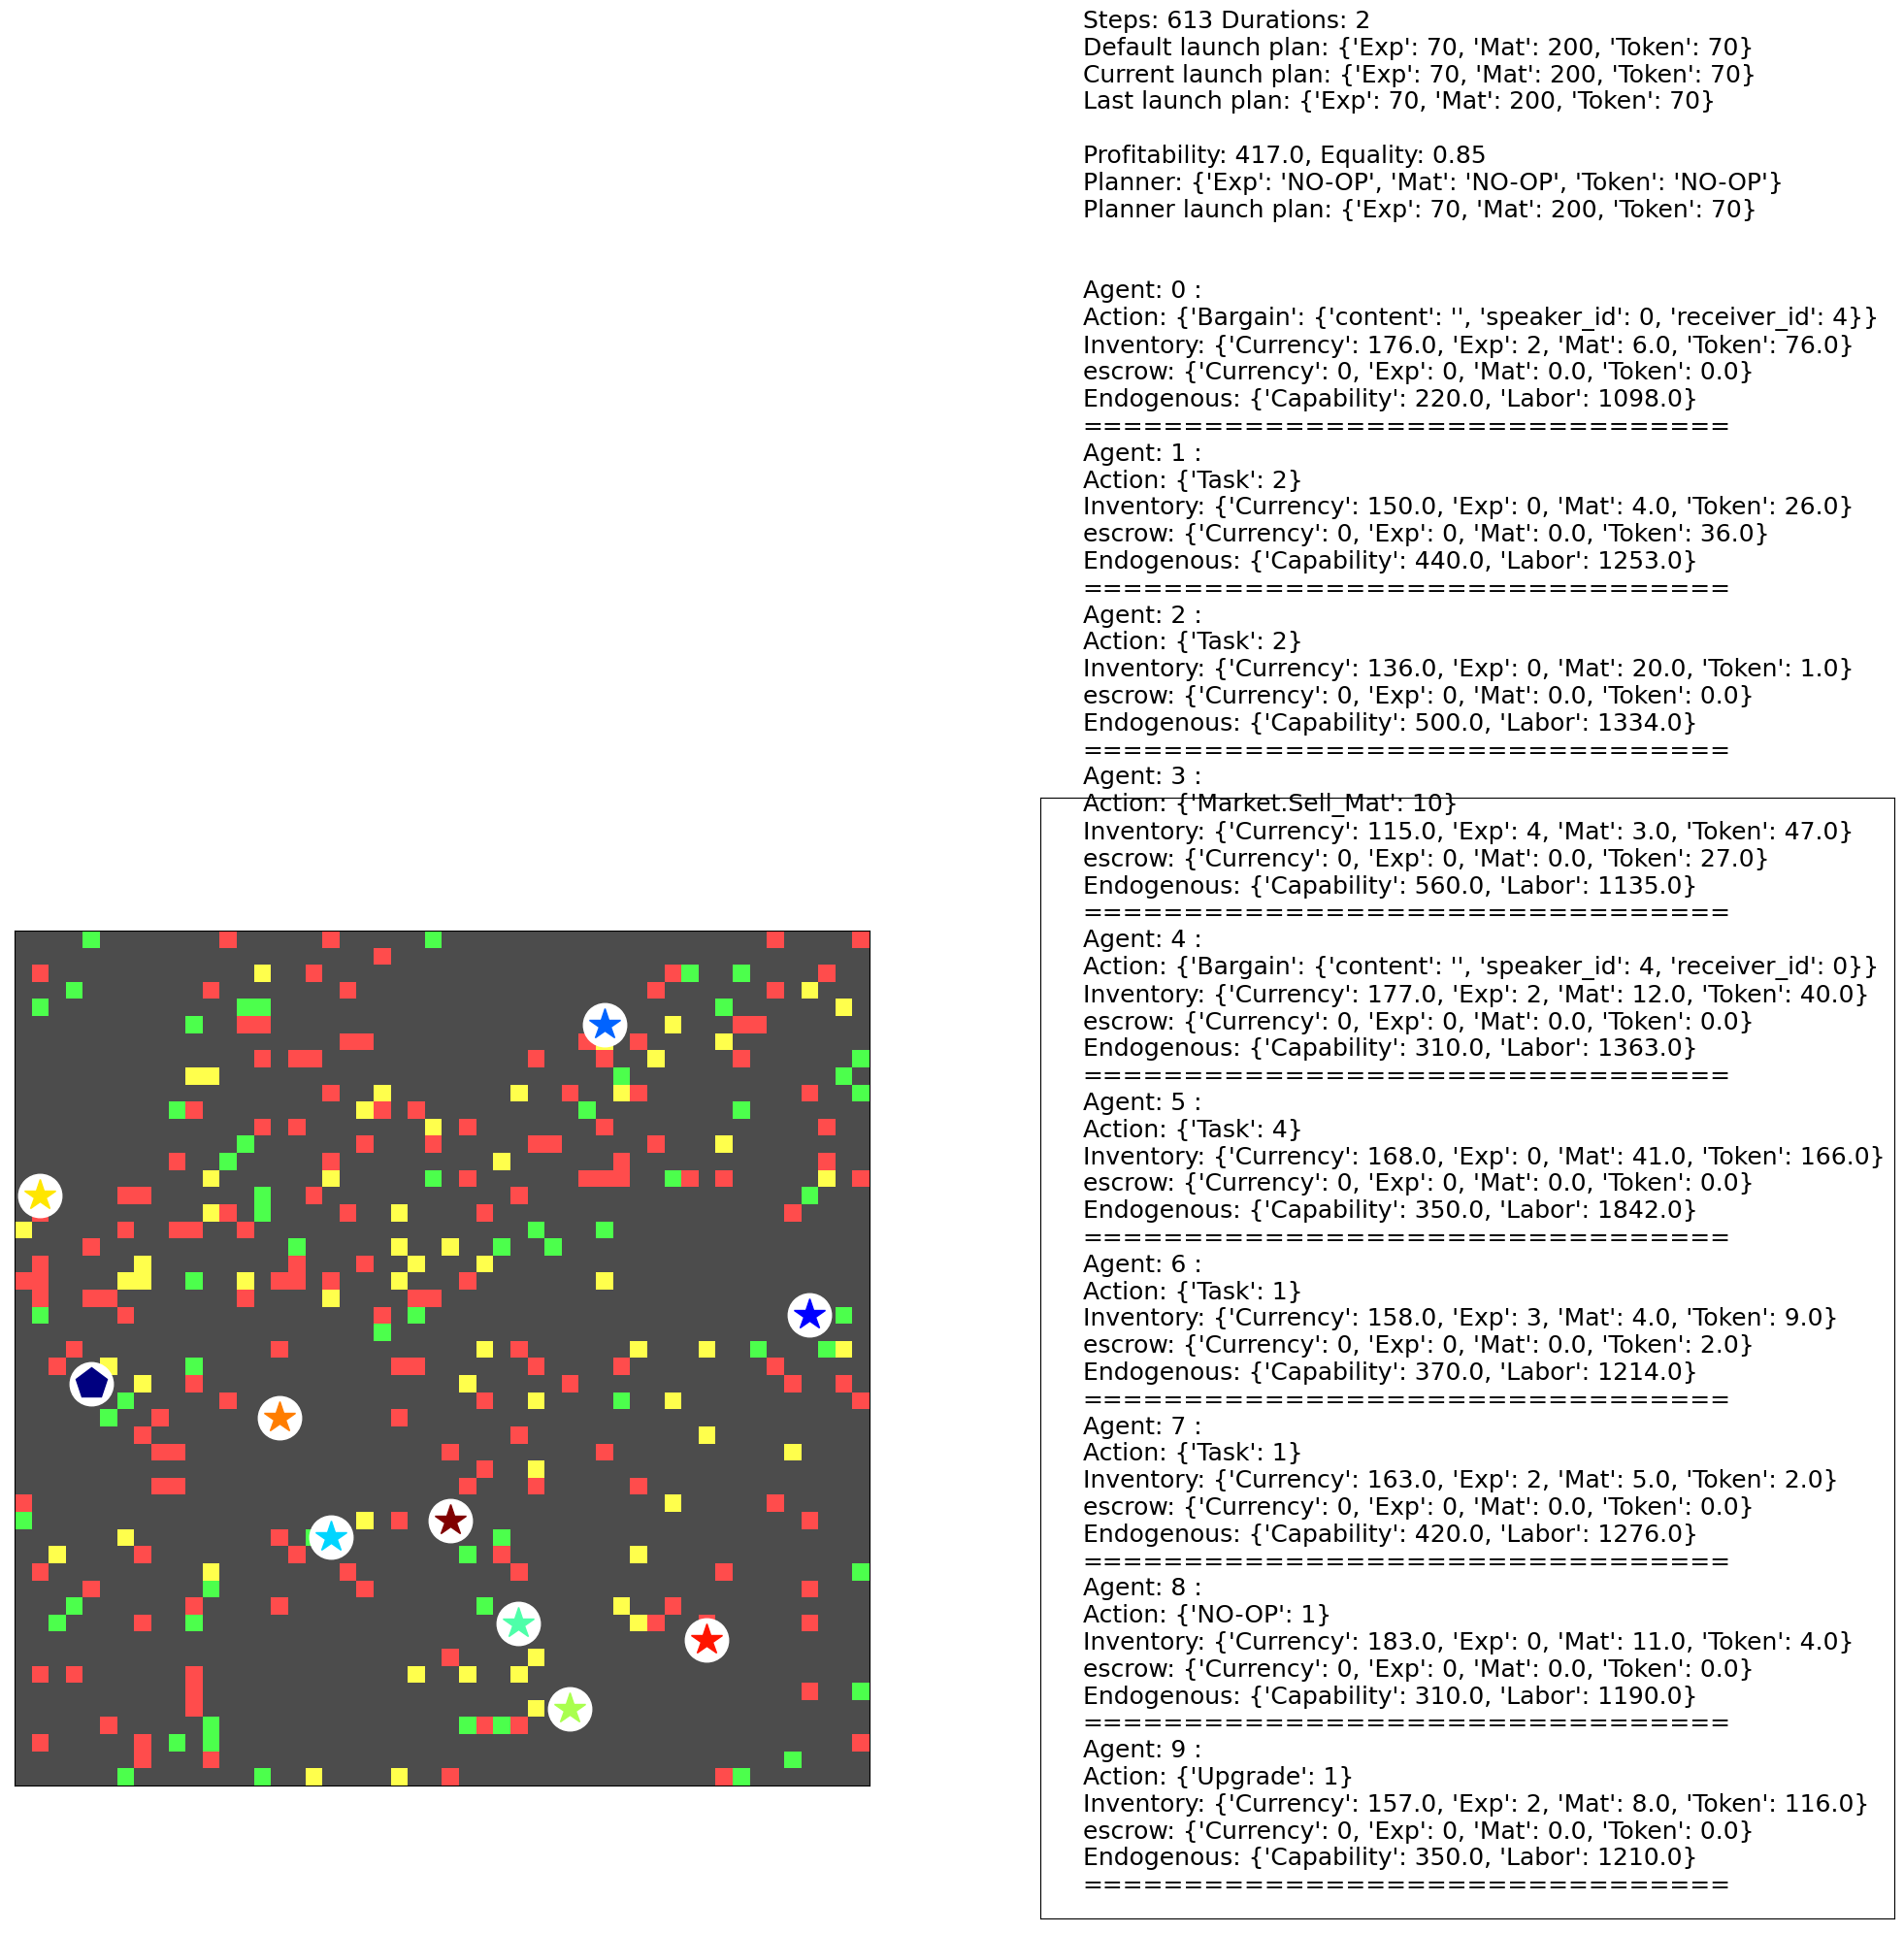

{'status': '102001', 'desc': 'OpenAI API代理服务繁忙，请稍后再试', 'detail': None, 'traceId': ''}
LLM call failed!
{'status': '102001', 'desc': 'OpenAI API代理服务繁忙，请稍后再试', 'detail': None, 'traceId': ''}
LLM call failed!
{'status': '102001', 'desc': 'OpenAI API代理服务繁忙，请稍后再试', 'detail': None, 'traceId': ''}
LLM call failed!
{'status': '102001', 'desc': 'OpenAI API代理服务繁忙，请稍后再试', 'detail': None, 'traceId': ''}
LLM call failed!
{'status': '102001', 'desc': 'OpenAI API代理服务繁忙，请稍后再试', 'detail': None, 'traceId': ''}
LLM call failed!
{'status': '102001', 'desc': 'OpenAI API代理服务繁忙，请稍后再试', 'detail': None, 'traceId': ''}
LLM call failed!


: 

In [7]:
play_random_episode(env, plot_every=1, do_dense_logging=True)

In [1]:
from foundation.utils import plotting
env._finalize_logs()
dense_log = env.previous_episode_dense_log
print(dense_log.keys())
plotting.breakdown(dense_log)

NameError: name 'env' is not defined

In [16]:
import json
with open("LLM_3.5_log_0523_70_6.txt", 'w') as f:
    f.write(json.dumps(dense_log))

In [17]:
file = open('trades_log0523_70_6.txt', 'w')
file.write(json.dumps([all_asks, all_bids]))

96377

In [2]:
actions_dist = []
for seq in decision_seqs:
    action_name, action_num = np.unique(seq, return_counts=True)
    actions_dist.append([(a,b) for a,b in zip(action_name, action_num)])
for i in range(len(actions_dist)):
    print(i, actions_dist[i])    
entropies = [entropy(np.unique(seq, return_counts=True)[1] / len(seq), base=2) for seq in decision_seqs]
print(entropies)

NameError: name 'decision_seqs' is not defined

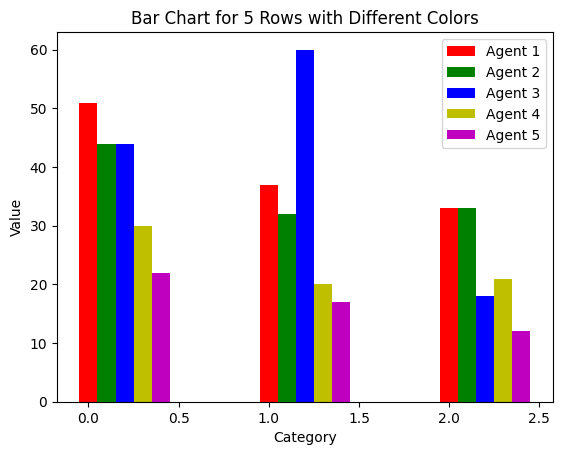

In [18]:
# Trade, Recharge, Shop
data = [[51,37,33,679],[44,32,33,683],[44,60,18,669],[30, 20,21,728],[22, 17,12,746]]
data = np.array(data)

# 创建颜色列表
colors = ['r', 'g', 'b', 'y', 'm']

# 绘制条形图
for i in range(5):
    plt.bar(np.arange(3) + 0.1 * i, data[i, :-1], color=colors[i], width=0.1, label='Agent {}'.format(i+1))

plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Bar Chart for 5 Rows with Different Colors')
plt.legend()
plt.show()

In [18]:
all_asks_cp, all_bids_cp = all_asks, all_bids

In [26]:
with open('../experiments/1000_steps/6_gpt_20_200/trades_log0522_200_20.txt', 'r') as f:
    all_asks, all_bids = json.loads(f.read())
with open('../experiments/1000_steps/6_gpt_20_200/LLM_3.5_log_0522_200_20.txt', 'r') as f:
    dense_log = json.loads(f.read())
decision_seqs = [[] for _ in range((len(dense_log['actions'][0])-1))]
for t in range(len(dense_log['actions'])):
    for i in range(len(dense_log['actions'][0])-1):
        act = dense_log["actions"][t][str(i)]
        act = act if len(act) > 0 else {'NO-OP': 1}
        decision_seqs[i].append(list(act.keys())[0])
actions_dist = []
for seq in decision_seqs:
    action_name, action_num = np.unique(seq, return_counts=True)
    actions_dist.append([(a,b) for a,b in zip(action_name, action_num)])
for i in range(len(actions_dist)):
    print(i, actions_dist[i])    
entropies = [entropy(np.unique(seq, return_counts=True)[1] / len(seq), base=2) for seq in decision_seqs]
print(entropies)

0 [('Bargain', 9), ('Market.Buy_Mat', 8), ('Market.Sell_Mat', 6), ('Recharge', 3), ('Shop', 2), ('Task', 169), ('Upgrade', 3)]
1 [('Bargain', 4), ('Market.Buy_Mat', 8), ('Market.Sell_Mat', 3), ('Recharge', 20), ('Shop', 9), ('Task', 155), ('Upgrade', 1)]
2 [('Bargain', 10), ('Market.Buy_Mat', 18), ('Market.Sell_Mat', 11), ('Recharge', 5), ('Shop', 4), ('Task', 145), ('Upgrade', 7)]
3 [('Bargain', 15), ('Market.Buy_Mat', 18), ('Market.Sell_Mat', 5), ('Recharge', 12), ('Shop', 6), ('Task', 141), ('Upgrade', 3)]
4 [('Bargain', 6), ('Market.Buy_Mat', 13), ('Market.Sell_Mat', 3), ('Recharge', 9), ('Shop', 2), ('Task', 166), ('Upgrade', 1)]
5 [('Bargain', 12), ('Market.Buy_Mat', 13), ('Market.Sell_Mat', 3), ('Recharge', 4), ('Task', 168)]
6 [('Bargain', 11), ('Market.Buy_Mat', 16), ('Market.Sell_Mat', 6), ('Recharge', 9), ('Shop', 1), ('Task', 156), ('Upgrade', 1)]
7 [('Bargain', 21), ('Market.Buy_Mat', 16), ('Market.Sell_Mat', 13), ('Recharge', 4), ('Shop', 3), ('Task', 139), ('Upgrade', 4)

In [19]:
# 记录收入方的mat， tok
in_mat = [[0 for _ in range(env.n_agents)] for _ in range(env.n_agents)]
in_tok = [[0 for _ in range(env.n_agents)] for _ in range(env.n_agents)]
records = dense_log["Bargain"]
print(records)
price = 0
trade_number = 0
bargain_t = []
bargain_price = []
for t in range(len(records)):
    record = records[t]
    if record:
        bargain_t.append(t)
        price_t = 0
        number_t = 0
        for trade in record:
            number_t += 1
            price_t += trade["new_price"]
            seller_id = trade["seller_id"]
            buyer_id = trade["buyer_id"]
            in_tok[buyer_id][seller_id] += trade["new_price"]
            in_tok[seller_id][buyer_id] -= trade["new_price"]
            in_mat[seller_id][buyer_id] += 1
            in_mat[buyer_id][seller_id] -= 1
        price += price_t
        trade_number += number_t
        bargain_price.append(price_t / number_t)
print(price/max(trade_number,0.001))
print(trade_number)
print(bargain_t)
print(bargain_price)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [{'new_price': 1, 'seller_id': 1, 'buyer_id': 4}], [], [], [{'new_price': 1, 'seller_id': 1, 'buyer_id': 3}], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [

9.0
[[ 0  3  0  0 -1  1]
 [-3  0  4  0  1  2]
 [ 0 -4  0  0  0  0]
 [ 0  0  0  0 -3  1]
 [ 1 -1  0  3  0  0]
 [-1 -2  0 -1  0  0]]
[-3 -4  4  2 -3  4]
[[  0 -27   0   0   9  -8]
 [ 27   0 -36   8  -1 -18]
 [  0  36   0   0   0   0]
 [  0  -8   0   0  27  -9]
 [ -9   1   0 -27   0   0]
 [  8  18   0   9   0   0]]
[ 26  20 -36 -10  35 -35]
nan nan
nan nan
0.11935977004414267 0.00021487338122989786
(array([ 86, 253, 326, 393, 394, 409, 423, 438, 464, 479, 486, 511, 594,
       605, 626, 633, 694, 709, 751, 760, 762, 763, 767, 768, 787, 792,
       899, 914, 926, 948], dtype=int64),)
(array([706, 707, 708, 709], dtype=int64),)
(array([706, 707, 708, 709], dtype=int64),)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 

C:\Users\xubihan\AppData\Local\Temp\ipykernel_45240\12998712.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(np.array(market_rate)[indices1],  -1 * (np.array(asks_num)[indices1] - np.array(bids_num)[indices1]))
C:\Users\xubihan\AppData\Local\Temp\ipykernel_45240\12998712.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(np.array(asks_avg_price)[indices2],  -1 * (np.array(asks_num)[indices2] - np.array(bids_num)[indices2]))


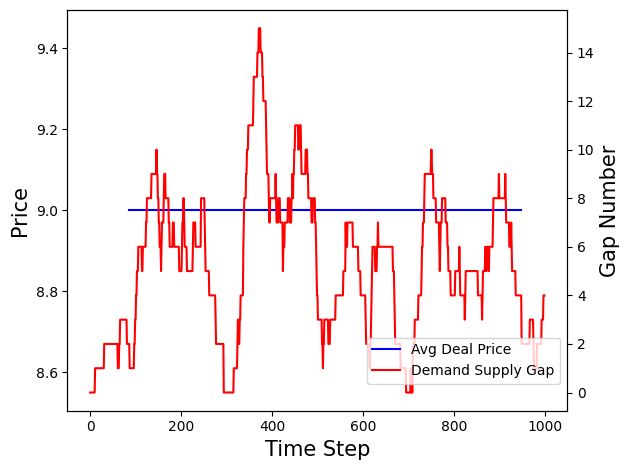

In [20]:
obs = env._generate_observations()
print(obs["1"]["Market-market_rate-Mat"])

time = []
market_rate = []
asks_num = []
bids_num = []
asks_avg_price = []
bids_avg_price = []
prices = np.arange(0, 11)
for t, trades in enumerate(dense_log["Trade_Market"]):
    if isinstance(trades, dict):
        trades_ = trades["trades"]
    else:
        trades_ = trades
    # if trades_:
    if 1:
        time.append(t)
        trades_price = [trade['price'] for trade in trades_]
        for trade in trades_:
            seller = trade['seller']
            buyer = trade['buyer']
            in_tok[buyer][seller] += trade['price']
            in_mat[seller][buyer] += 1
            in_tok[seller][buyer] -= trade['price']
            in_mat[buyer][seller] -= 1
        market_rate.append(sum(trades_price) / max(0.001, len(trades_price)))
        asks_num.append(sum(all_asks[t]))
        asks_avg_price.append(prices.dot(np.array(all_asks[t]/np.maximum(0.001, sum(all_asks[t])))))
        bids_avg_price.append(prices.dot(np.array(all_bids[t]/np.maximum(0.001, sum(all_bids[t])))))
        bids_num.append(sum(all_bids[t]))

print(np.array(in_mat))
print(np.sum(np.array(in_mat), 0))
print(np.array(in_tok))
print(np.sum(np.array(in_tok), 0))
from scipy.stats import pearsonr

indices1 = np.where(np.array(market_rate) > 0)
correlation, p_value = pearsonr(np.array(market_rate)[indices1],  -1 * (np.array(asks_num)[indices1] - np.array(bids_num)[indices1]))
print(correlation, p_value)
indices2 = np.where(np.array(asks_avg_price) > 0)
indices2_2 = np.where(np.array(asks_num) > 0)
correlation, p_value = pearsonr(np.array(asks_avg_price)[indices2],  -1 * (np.array(asks_num)[indices2] - np.array(bids_num)[indices2]))
print(correlation, p_value)
indices3 = np.where(np.array(bids_avg_price) > 0)
correlation, p_value = pearsonr(np.array(bids_avg_price)[indices3],  -1 * (np.array(asks_num)[indices3] - np.array(bids_num)[indices3]))
print(correlation, p_value)

print(indices1)
print(indices2)
print(indices2_2)
print(np.array(all_asks)[indices1])
# plt.scatter(market_rate, -1 * (np.array(asks_num) - np.array(bids_num)))
# plt.plot(time, -1 * (np.array(asks_num) - np.array(bids_num)), label = 'asks_num')
'''plt.plot(time, market_rate, label = 'market_rate')
plt.plot(time, asks_num, label = 'asks_num')
plt.plot(time, bids_num, label = 'bids_num')
plt.legend()'''
time1 = np.array(time)[indices1]
market_rate1 = np.array(market_rate)[indices1]
sub = -1 * (np.array(asks_num) - np.array(bids_num))
print(len(time1))
fig, ax1 = plt.subplots()
import matplotlib
matplotlib.rcdefaults()
# plt.scatter(sub[indices1],market_rate1)
ax1.plot(time1, market_rate1,color='blue', label="Avg Deal Price")
# ax1.plot(np.array(time)[indices2], np.array(asks_avg_price)[indices2],color='blue', label="Avg Deal Price")
# ax1.plot(bargain_t, bargain_price, label = 'Avg Bargain Price')
ax1.set_xlabel("Time Step",fontsize=15)
ax1.set_ylabel("Price", fontsize=15)

ax2 = ax1.twinx()
ax2.plot(time, sub, color= 'red', label="Demand Supply Gap")
ax2.set_ylabel("Gap Number",fontsize=15)
# plt.plot(time, bids_avg_price, label = 'bids_avg')
# plt.plot(time, sub, label = 'bids_num')
fig.legend(bbox_to_anchor=(1, 0.2), bbox_transform=ax1.transAxes)

# plt.title('market rate of material on each time step')
plt.tight_layout()
plt.show()

In [ ]:
cap = [env.world.agents[i].endogenous["Capability"] for i in range(env.n_agents)]
print(cap)
print(sum(cap)/env.n_agents)

In [ ]:
print(entropies)
print(sum(entropies)/len(entropies))

In [ ]:
file_path = 'LLM_log_0428_50_avg90_task2_noforget.txt'
with open(file_path, 'r') as file:
    dense_log = json.load(file)
print(dense_log.keys())
print(dense_log['states'][199]['0']['endogenous'])

In [ ]:
ENV 70, 70, 70
Tree: [73,70,68，68，71][73, 73, 69] [87, new direction, upgrade first] 【84 no upgrade first, 86】
ReAct: [33, 35,27,26,25]
new_ReAct:[58,53,52,] [41,44,][46,48] # market [3.4444]
Reflexion:[51][43]
Random:[35]
LLM: [86,92,96, 97, 95] [93,] 
    successful memory + task continue 2 [138, 118，]
    checkmulti [88]
llama [104,]  checkmulti [89] 
Act: [32, 30, 45][25， 27]
    
ENV 50 50 50
LLM:[80.0,75, 76][63 ,65 masked action] 
    succssful memory: [83] 
        task continue 2 [68] no forgetting [90]
llama [82.0]

Random: [34]
Tree [71][68 no upgrade first]
    
ENV 30 30 30
wo cycle reflect LLM: [40]
with reflect LLM: [50,44] 
    successful memory【49】 [60] 
    task continue 2 [49 ] no forget [60,]
    no forget no task continue [62,]
tree [58, 57,59, 61,57] [56]
llama [68]

In [ ]:
# entropy
random = [2.5715,]
ReAct = [1.5475,1.4496,1.5043][1.6280, 1.6065][1.1216, 0.8737]
Reflexion = [1.2086][1.0576]
Act = [[1.4845, 1.7421, 1.5534] [0.9860, 1.2525]
LLM = [1.6766, 1.8353] [0.9275] 
       task continue 2 [1.1760， 1.0484]
       checkmulti [1.4365] task full
llama [1.1582] check multi[1.4459]
Tree = [2.3857, 2.3716, 2.3511] [2.0569][2.0541, 2.0947]
       
ENV 50 50 50
LLM: [1.2561,0.9878, 0.9379][1.4239,1.3742] succssful memory: [0.9229] task continue 2 [1.0014] no forgetting [1.0867]
llama [1.0156]
Random: [2.5649]
Tree: [2.0328][2.0625]
       
ENV 30 30 30
wo cycle reflect LLM [1.1504]
with cycle reflect LLM [0.8540, 1.1413] 
       successful memory【0.8476】[0.9056] 
       task continue 2 [0.9507] no forget [1.0165]
       no task continue no forget [1.0430]
llama [0.9850]

tree [1.9458, 2.0444,1.9430, 1.9716 ,1.9821] [1.9610]


In [ ]:
print(dense_log.keys())
print(dense_log["Trade_Market"])

In [ ]:
import ipywidgets as widgets	# 控件库
from IPython.display import display	# 显示控件的方法
import asyncio
action_number = 0
        
text_input = widgets.Text(description='Input:')
display(text_input)
def process_input2(sender):
    print('process 2')
def process_input(sender):
    value = text_input.value
    action_number = value
    print(action_number)
    text_input2 = widgets.Text(description='Input:')
    display(text_input2)
    text_input2.on_submit(process_input2)
    
text_input.on_submit(process_input)
loop = asyncio.get_event_loop()

# 等待事件循环结束
await loop.create_future()
print('finish')